# Rule Trends - by Location
## Buisness Question: Do purchases vary by destination location?
Andrew Reichel



List:
- MBA All Trans

TODO:
- MBA All Returns

### Configure libraries and load dataset (previously aggregated into csv from discrete xlsx)

In [118]:
import pandas as pd
import numpy as np
import sys, os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.metrics import jaccard_similarity_score

''' setup paths '''
data_dir = '../data/'

for doc in os.listdir(data_dir):
    if doc.endswith('csv'):
        df_0911 = pd.read_csv(os.path.join(data_dir,doc),index_col=0)
df_0911.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [2]:
df_0911.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### Establish frunctions to prep data and mine rules

In [3]:
def cleanup_df(df_in):
    ''' clean up DESCRIPTION col of df_in to:
            1. remove spaces
            2. drop rows w/o invoice numbers
            3. drop postage row
            4. remove returned transactions (C) '''
    # drop extra spaces
    df_in.loc[:,'Description'] = df_in.loc[:,'Description'].str.strip()
    # drop rows w/o invoice number
    #df_in.dropna(axis=0, subset=['Invoice'], inplace=True)
    df_in.loc[:,'Invoice'] = df_in.loc[:,'Invoice'].astype(str)
    # drop postage row
    #df_in = df_in.Description.drop('POSTAGE', axis = 0)
    # drop Invoice == 'C' rows
    df_in = df_in[~df_in.loc[:,'Invoice'].str.contains('C')]
    
    return df_in

def encode_purch(item):
    ''' set all instances of purchase to 1, else == 0
        drop postage column '''
    if item >= 1:
        return 1
    else:
        return 0

def make_basket(df_in):
    ''' setup basket for MBA 
            1. One Hot Encode transactions 
            2. '''
    df_cleaned = cleanup_df(df_in)
    basket = (df_cleaned.groupby(['Invoice','Description'])['Quantity']
              .sum().unstack().reset_index().fillna(0).set_index('Invoice'))
    
    basket = basket.applymap(encode_purch)
    #print basket.POSTAGE
    if 'POSTAGE' in basket.columns:
        basket = basket.drop('POSTAGE', axis = 1)
    return basket

def mine_rules(country, min_supp = 'NA', verbose = False):  
    ''' function to extract rules or perform min_supp sensitivity test if no
        min_supp is provided '''
    # find orders by country
    df_country = df_0911[df_0911.Country == country]
    
    # make baskets
    baskets = make_basket(df_country)
    print "len of basket: ",len(baskets)
    
    ''' if min_supp not given, run sensitivity test on minsupp, else find
        all association rules '''
    if min_supp == 'NA':
        items = {}
        for min_sup in np.linspace(0.41, 0.02, 35):
            frq_itms = apriori(baskets, min_support=min_sup, use_colnames=True)
            items[min_sup] = len(frq_itms)
            if verbose == True:
                print "Considering Min_Supp: {}: {}".format(min_sup, len(frq_itms))
        freq_items = pd.DataFrame.from_dict(items, orient='index')
        return items
    else:
        freq_items = apriori(baskets, min_support=min_supp, use_colnames=True)
        rules = association_rules(freq_items, metric='confidence', min_threshold=0.35)
        return rules


### Test on USA Orders 

In [4]:
df_USorders = df_0911[df_0911.Country == 'USA']
print "US Orders: ", len(df_USorders.Invoice.unique())
df_USorders.head()

US Orders:  25


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
126,489444,POST,POSTAGE,1,2009-12-01 09:55:00,141.00,12636.0,USA
51589,494110,21268,VINTAGE BLUE TINSEL REEL,24,2010-01-11 12:29:00,2.10,12549.0,USA
51590,494110,21412,VINTAGE GOLD TINSEL REEL,11,2010-01-11 12:29:00,0.42,12549.0,USA
51591,494110,22083,PAPER CHAIN KIT RETRO SPOT,6,2010-01-11 12:29:00,2.95,12549.0,USA
51592,494110,22084,PAPER CHAIN KIT EMPIRE,6,2010-01-11 12:29:00,2.95,12549.0,USA


In [5]:
print make_basket(df_USorders).shape
baskets = make_basket(df_USorders)
baskets.head()

(20, 303)


/Users/areichel/opt/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Description,12 PENCILS SMALL TUBE RED RETROSPOT,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 DOILIES SPACEBOY DESIGN,5 HOOK HANGER MAGIC TOADSTOOL,5 HOOK HANGER RED MAGIC TOADSTOOL,6 GIFT TAGS 50'S CHRISTMAS,6 GIFT TAGS VINTAGE CHRISTMAS,60 CAKE CASES DOLLY GIRL DESIGN,...,VINTAGE UNION JACK BUNTING,VINTAGE UNION JACK SHOPPING BAG,WOOD STAMP SET BEST WISHES,WOODLAND DESIGN COTTON TOTE BAG,WRAP CHRISTMAS VILLAGE,WRAP COWBOYS,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP I LOVE LONDON,WRAP WEDDING DAY
Invoice,,,,,,,,,,,,,,,,,,,,,
489444,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494234,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494891,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0


(0.42, 0.04)

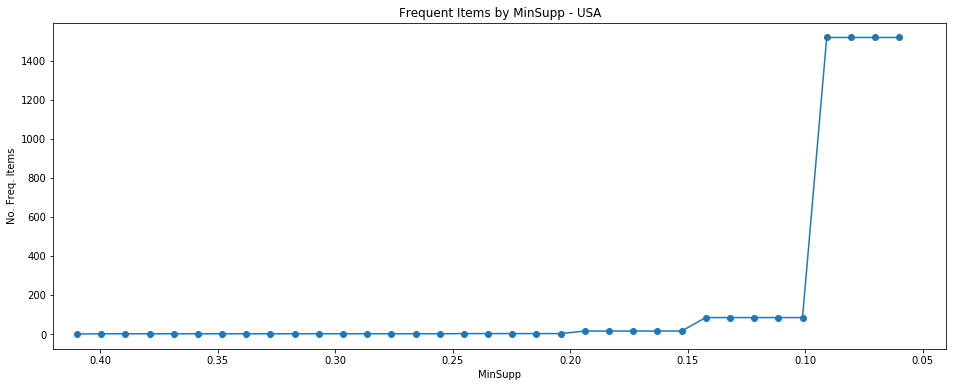

In [6]:
''' find minsupp sensitivity '''
items = {}
for min_sup in np.linspace(0.41, 0.06, 35):
    #print "Considering Min_Supp: ", min_sup
    frq_itms = apriori(baskets, min_support=min_sup, use_colnames=True)
    items[min_sup] = len(frq_itms)

freq_items = pd.DataFrame.from_dict(items, orient='index')

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
ax.set_title('Frequent Items by MinSupp - USA')
ax.set_xlabel('MinSupp')
ax.set_ylabel('No. Freq. Items')
ax.scatter(freq_items.index, freq_items.iloc[:,0])
ax.plot(freq_items.sort_index())
ax.set_xlim(0.42, 0.04)

### Find ideal min_supp, by country

In [58]:
print "Unique Countries in Data: {}".format(len(df_0911.Country.unique()))

country_ords = {}
for country in df_0911.Country.unique():
    tmp = df_0911[df_0911.Country == country]
    #print country, len(tmp)
    country_ords[country] = len(tmp.Invoice.unique())

df_ords_Country = pd.DataFrame.from_dict(country_ords, orient='index',columns=['Order Count'])

Unique Countries in Data: 43


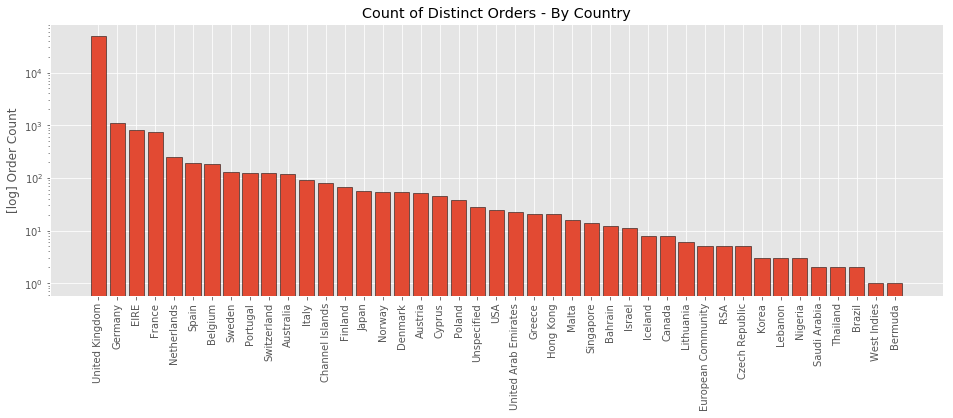

In [8]:
''' plot of Order Count by Country '''
plt.style.use('ggplot')
df_ords_Country = df_ords_Country.sort_values(['Order Count'], axis=0, ascending=False)
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
ax.set_title('Count of Distinct Orders - By Country')
ax.set_ylabel('[log] Order Count')
ax.bar(df_ords_Country.index,df_ords_Country['Order Count'],edgecolor='black')
plt.yscale('log')
plt.xticks(rotation = 90);

### Identify Top 5 countries for rule mining

In [9]:
df_ords_Country = df_ords_Country.sort_values(by=['Order Count'], axis=0, ascending=False)
top_countries = df_ords_Country.index[:22]

Use uniform min_supp

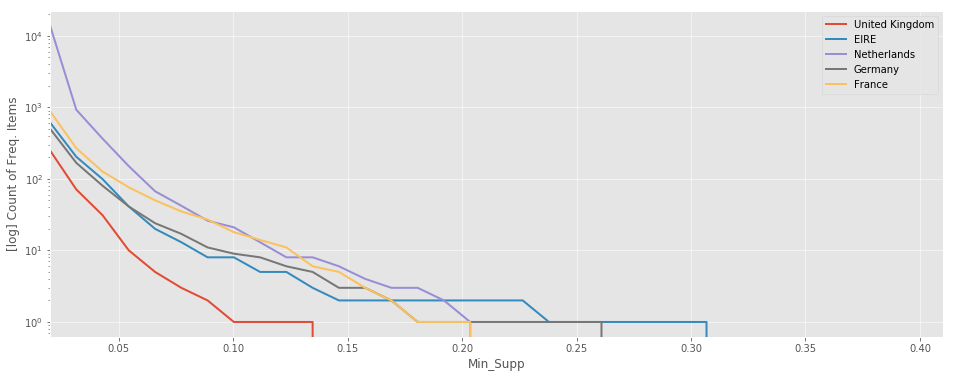

In [80]:
''' plot of freq items by min supp '''
min_sup_df = pd.read_csv('../results/freq_item_count.csv', index_col=0)

fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
ax.set_xlabel('Min_Supp')
ax.set_ylabel('[log] Count of Freq. Items')
min_sup_df.sort_index().plot(figsize = (16,6), ax=ax)
plt.yscale('log')

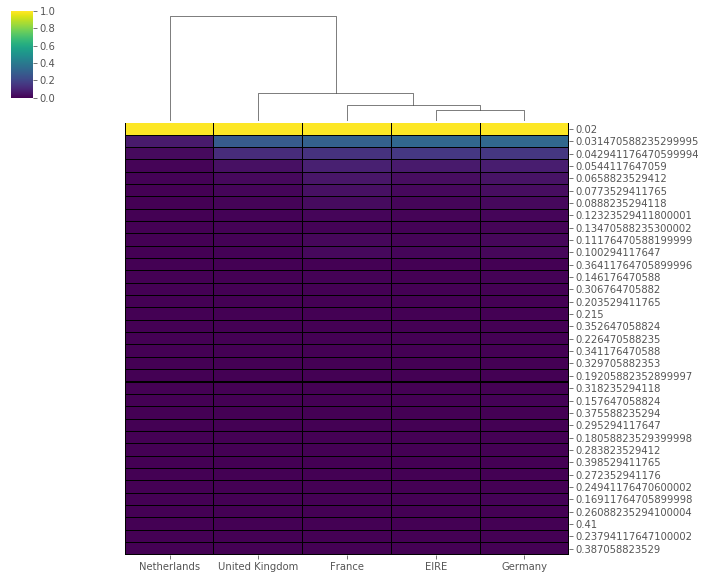

In [11]:
sns.clustermap(min_sup_df,standard_scale=1, row_cluster=False, cmap = 'viridis', 
               linewidth=0.005, linecolor='black');

In [12]:
frq_items = {}

for country in top_countries:
    if country != 'United Arab Emirates':
        print country
        country_df = df_0911[df_0911.Country == country]
        country_df_sparse = make_basket(country_df)
        country_frqItems = apriori(country_df_sparse, min_support=0.1, use_colnames=True)
        print "Frequent Items: {}".format(len(country_frqItems))
        item_set_len = []
        for i in country_frqItems.itemsets:
            item_set_len.append(len(i))
        country_frqItems['set_len'] = item_set_len

        # write to frq_items
        frq_items[country] = country_frqItems 
        print "max length of freq itemset: ",country_frqItems.set_len.max()

United Kingdom
Frequent Items: 1
max length of freq itemset:  1
Germany
Frequent Items: 9
max length of freq itemset:  2
EIRE
Frequent Items: 8
max length of freq itemset:  1
France
Frequent Items: 18
max length of freq itemset:  2
Netherlands
Frequent Items: 21
max length of freq itemset:  2
Spain
Frequent Items: 5
max length of freq itemset:  1
Belgium
Frequent Items: 24
max length of freq itemset:  3
Sweden
Frequent Items: 5
max length of freq itemset:  1
Portugal
Frequent Items: 25
max length of freq itemset:  2
Switzerland
Frequent Items: 32
max length of freq itemset:  3
Australia
Frequent Items: 5
max length of freq itemset:  1
Italy
Frequent Items: 20
max length of freq itemset:  2
Channel Islands
Frequent Items: 47
max length of freq itemset:  3
Finland
Frequent Items: 11
max length of freq itemset:  2
Japan
Frequent Items: 24
max length of freq itemset:  3
Norway
Frequent Items: 65
max length of freq itemset:  3
Denmark
Frequent Items: 31
max length of freq itemset:  3
Austri

In [42]:
skip = ['USA']

items_sub = {}
for country in frq_items:
    if country not in skip:
        items_sub[country] = frq_items[country]

['EIRE',
 'Australia',
 'Italy',
 'Portugal',
 'Denmark',
 'Poland',
 'Finland',
 'Channel Islands',
 'Austria',
 'Unspecified',
 'France',
 'United Kingdom',
 'Switzerland',
 'Sweden',
 'Netherlands',
 'Germany',
 'Belgium',
 'Japan',
 'Cyprus',
 'Norway',
 'Spain']

In [65]:
country_item_count = {}
for country in items_sub:
    country_item_count[country] = len(items_sub[country])
    
items_country = pd.DataFrame.from_dict(country_item_count, orient='index')

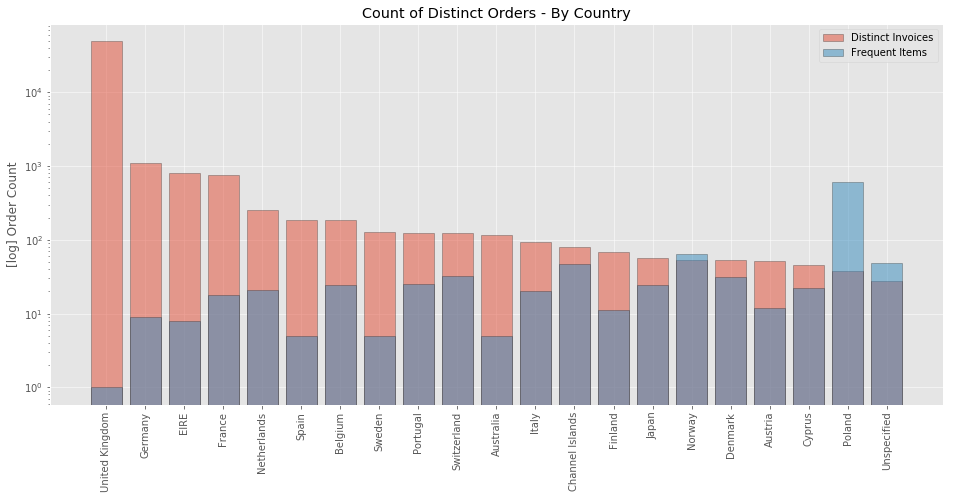

In [77]:
plt.style.use('bmh')

''' plot of Order Count by Country '''
plt.style.use('ggplot')
df_ords_Country = df_ords_Country.sort_values(['Order Count'], axis=0, ascending=False)[:21]
df_ords_Country['freq_items'] = items_country.iloc[:,0]

fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot(111)
ax.set_title('Count of Distinct Orders - By Country')
ax.set_ylabel('[log] Order Count')
ax.bar(df_ords_Country.index,df_ords_Country['Order Count'], alpha=0.5, edgecolor='black')
ax.bar(df_ords_Country.index, df_ords_Country.freq_items, alpha = 0.5, edgecolor='black')
plt.yscale('log')
plt.xticks(rotation = 90);
plt.legend(['Distinct Invoices','Frequent Items'])


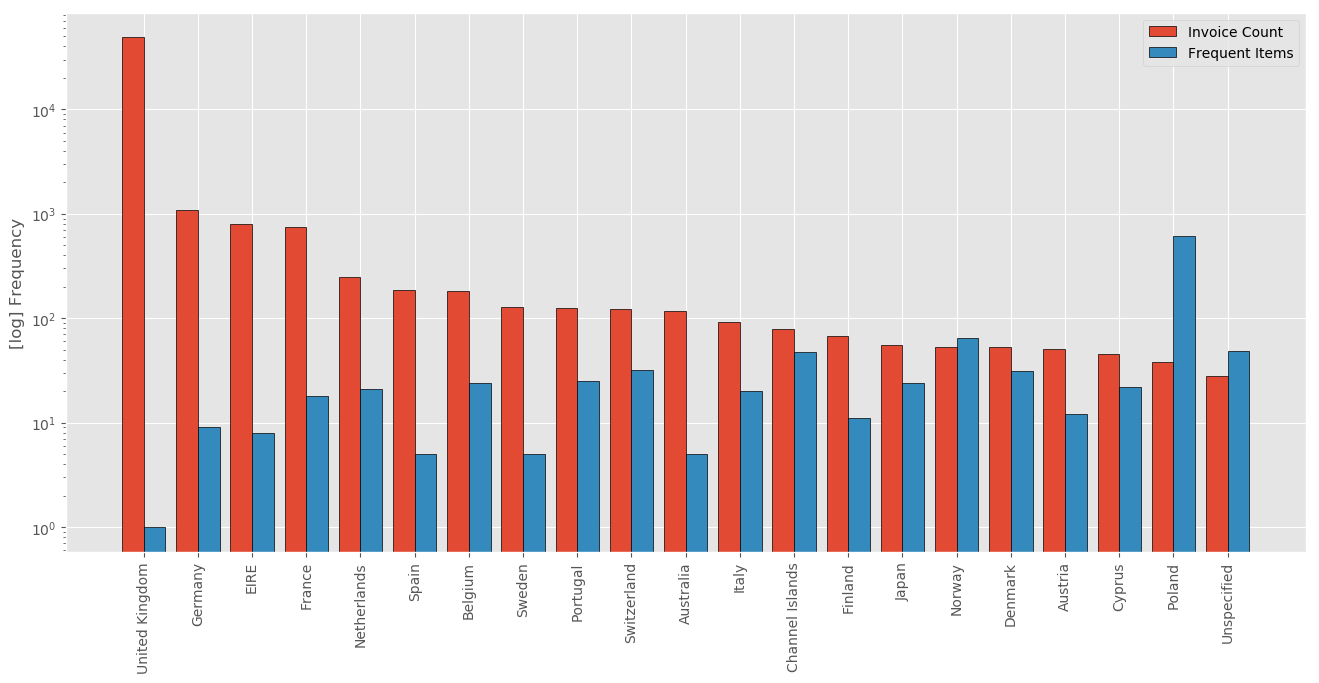

In [252]:
fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot(111)
ax.set_ylabel('[log] Frequency')

orders = df_ords_Country['Order Count']
frqItems = df_ords_Country.freq_items

inds = np.arange(len(df_ords_Country.index))
width = 0.4

ax.bar(inds, orders, width, edgecolor = 'black')
ax.bar(inds+width, frqItems, width, edgecolor = 'black')

plt.yscale('log')
plt.legend(['Invoice Count','Frequent Items'])
plt.xticks(inds+width/2, df_ords_Country.index, rotation=90);

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)


In [36]:
''' create Itemset dict'''
item_count = {}
for country in items_sub:
    for itemset in frq_items[country].itemsets:
        item_count[str(itemset)] = 0
for country in items_sub:
    for itemset in frq_items[country].itemsets:
        item_count[str(itemset)] += 1

In [37]:
frq_df = pd.DataFrame.from_dict(item_count, orient='index', columns=['Count']).reset_index()

frq_df.sort_values('Count', ascending=False)

,index,Count
707,['REGENCY CAKESTAND 3 TIER'],11
564,['RED TOADSTOOL LED NIGHT LIGHT'],10
203,['ROUND SNACK BOXES SET OF 4 FRUITS'],8
178,['WHITE HANGING HEART T-LIGHT HOLDER'],7
234,['PLASTERS IN TIN WOODLAND ANIMALS'],7
273,['ROUND SNACK BOXES SET OF4 WOODLAND'],7
7,['PLASTERS IN TIN CIRCUS PARADE'],7
778,['PLASTERS IN TIN SPACEBOY'],6
790,['SPACEBOY LUNCH BOX'],6
393,"['ROUND SNACK BOXES SET OF 4 FRUITS', 'ROUND S...",5


In [43]:
''' create sparse matrix of freq items by country'''
freqItems_Country = pd.DataFrame()
for country in items_sub:
    itemsets = []
    tmp_df = pd.DataFrame()
    print country
    tmp = frq_items[country]
    for i in tmp.itemsets:
        itemsets.append(str(i))
    tmp_df['itemset'] = itemsets
    tmp_df['country'] = [country]*len(tmp)
    tmp_df['support'] = tmp.support
    
    freqItems_Country = pd.concat([freqItems_Country,tmp_df],axis=0)

EIRE
Australia
Italy
Portugal
Denmark
Poland
Finland
Channel Islands
Austria
Unspecified
France
United Kingdom
Switzerland
Sweden
Netherlands
Germany
Belgium
Japan
Cyprus
Norway
Spain


In [44]:
freqItems_Country
freqItems_Country = freqItems_Country[~(freqItems_Country.country == 'Poland')]# &
                                      #~(freqItems_Country.country == 'Unspecified')]

In [46]:
''' generate sparse matrix of itemset support '''

sparse_raw = freqItems_Country.set_index('country')#.drop('Poland')
sparse_supp = sparse_raw.pivot_table(index='country',columns='itemset',values='support',fill_value=0)

sparse_supp.columns = range(len(sparse_supp.T))
#sparse_supp = sparse_supp.drop(['USA'])

In [47]:
freqItems_Country.country.unique()

array(['EIRE', 'Australia', 'Italy', 'Portugal', 'Denmark', 'Finland',
       'Channel Islands', 'Austria', 'Unspecified', 'France',
       'United Kingdom', 'Switzerland', 'Sweden', 'Netherlands',
       'Germany', 'Belgium', 'Japan', 'Cyprus', 'Norway', 'Spain'],
      dtype=object)

<Figure size 1152x576 with 0 Axes>

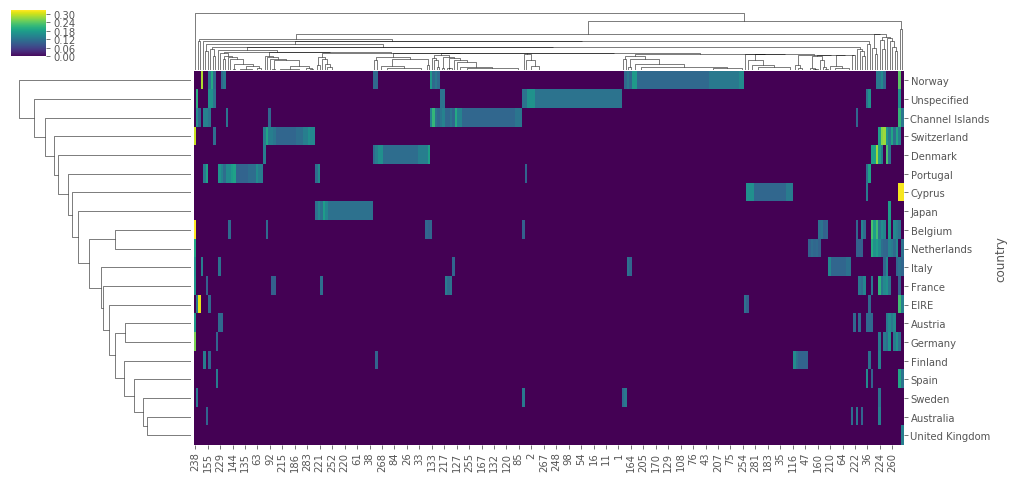

In [82]:
fig = plt.figure(figsize=(16,8))
sns.clustermap(sparse_supp,figsize=(16,8), cmap='viridis');#,linewidth=.005, linecolor='dimgrey');


In [19]:
from sklearn.metrics import silhouette_score

In [20]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3).fit_predict(sparse_supp)

In [109]:
def means_sensitivity(df_in, method='kmeans'):
  ''' <> '''
  clust_eff = {}
  for mean in range(2,11):
    if method == 'kmeans':
      kmeans = KMeans(n_clusters = mean).fit(df_in)
      sil_score = silhouette_score(df_in, kmeans.labels_)
      clust_eff[mean] = [kmeans.inertia_, sil_score, kmeans.n_iter_]
      df_summ = pd.DataFrame.from_dict(clust_eff, orient='index', columns=['Inertia','sil_score','n_iter'])
    if method == 'gmm':
      gmm = GaussianMixture(n_components = 4).fit_predict(df_in)
      sil_score = silhouette_score(df_in, gmm)
      clust_eff[mean] = [sil_score]#, gmm.n_iter_]
      df_summ = pd.DataFrame.from_dict(clust_eff, orient='index', columns=['sil_score'])#,'n_iter'])
    
  
  
  ''' plot of inertia by centroid count '''
  plt.style.use('bmh')
  fig = plt.figure(figsize=(8,6))
  ax = fig.add_subplot(111)
  ax.set_xlabel('Num. Centroids')
  ax.set_ylabel('Inertia $\Sigma_{k}^K|i-k|$')
  if method == 'kmeans':
    ax.scatter(df_summ.index,df_summ.Inertia)
    ax.plot(df_summ.index, df_summ.Inertia)
    ax.set_xticks(df_summ.index)
  axr = ax.twinx()
  axr.scatter(df_summ.index, df_summ.sil_score, color = 'g')
  axr.plot(df_summ.index, df_summ.sil_score, color = 'g')
  axr.set_ylabel('Avg Silhouette Score')
  #axr.set_yticks(np.linspace(0.06, 0.15, 7))

In [23]:
from sklearn.cluster import AgglomerativeClustering

hier = AgglomerativeClustering(n_clusters=3).fit(sparse_supp)

(array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115, 125,
        135, 145, 155, 165, 175, 185, 195]),
 <a list of 20 Text xticklabel objects>)

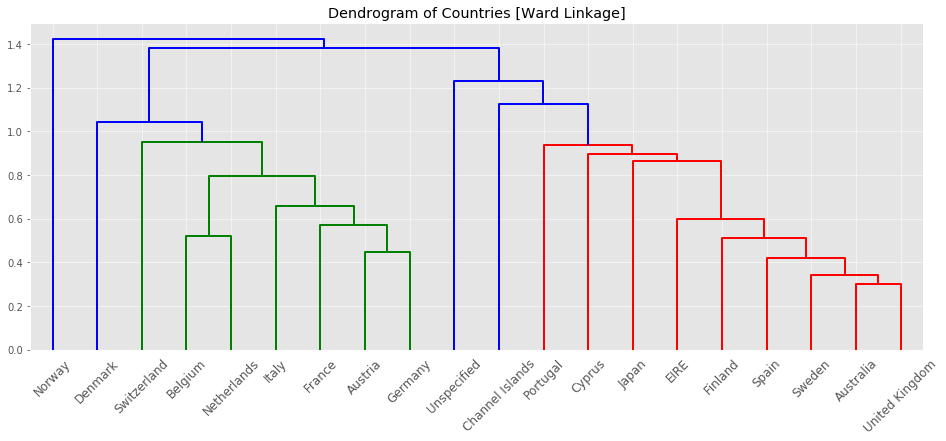

In [84]:
from scipy.cluster import hierarchy

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
ax.set_title('Dendrogram of Countries [Ward Linkage]')
z = hierarchy.linkage(sparse_supp, 'ward')
dend = hierarchy.dendrogram(z, labels=sparse_supp.T.columns);
plt.xticks(rotation = 45)

In [25]:
sparse_supp.T.columns.unique()

Index([u'Australia', u'Austria', u'Belgium', u'Channel Islands', u'Cyprus',
       u'Denmark', u'EIRE', u'Finland', u'France', u'Germany', u'Italy',
       u'Japan', u'Netherlands', u'Norway', u'Portugal', u'Spain', u'Sweden',
       u'Switzerland', u'United Kingdom', u'Unspecified'],
      dtype='object', name=u'country')

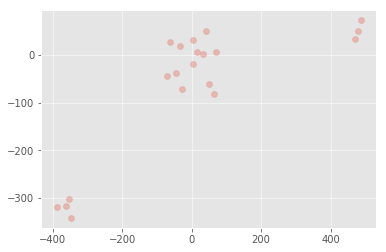

In [102]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, perplexity=1).fit_transform(sparse_supp)

plt.scatter(X_tsne[:,0], X_tsne[:,1], alpha = 0.3)

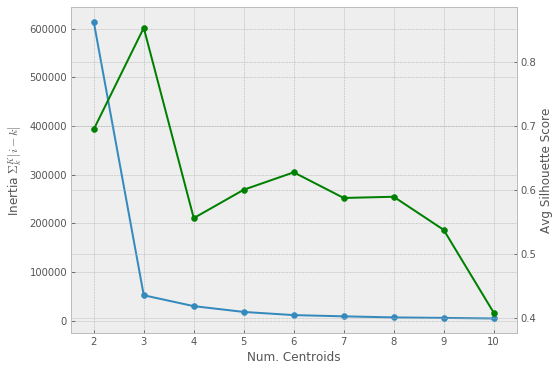

In [110]:
means_sensitivity(X_tsne)

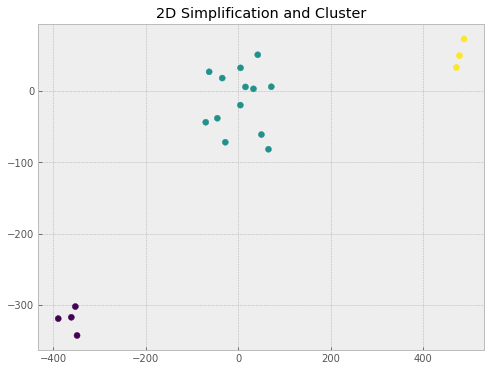

In [113]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init= 1000).fit_predict(X_tsne)
gmm = GaussianMixture(n_components=3, n_init=1000).fit_predict(X_tsne)

c0 = kmeans
c1 = gmm

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.set_title('2D Simplification and Cluster')
ax.scatter(X_tsne[:,0], X_tsne[:,1], c=c0, cmap='viridis')

### Jaccard Distance

In [168]:
def bin_encode(array):
    output = []
    for i in array:
        if i>0:
            output.append(int(1))
        else: output.append(int(0))
        
    return output

jacc_dict = {}
for country in sparse_supp.T.columns.unique():
    country_items = bin_encode(sparse_supp.T[country])
    country_arr = []
    print country
    for comp_country in sparse_supp.T:
        print "\t",comp_country
        compare_to = bin_encode(sparse_supp.T[comp_country])
        sim_score = jaccard_similarity_score(country_items, compare_to)
        country_arr.append(sim_score)
    jacc_dict[country] = country_arr

Australia
	Australia
	Austria
	Belgium
	Channel Islands
	Cyprus
	Denmark
	EIRE
	Finland
	France
	Germany
	Italy
	Japan
	Netherlands
	Norway
	Portugal
	Spain
	Sweden
	Switzerland
	United Kingdom
	Unspecified
Austria
	Australia
	Austria
	Belgium
	Channel Islands
	Cyprus
	Denmark
	EIRE
	Finland
	France
	Germany
	Italy
	Japan
	Netherlands
	Norway
	Portugal
	Spain
	Sweden
	Switzerland
	United Kingdom
	Unspecified
Belgium
	Australia
	Austria
	Belgium
	Channel Islands
	Cyprus
	Denmark
	EIRE
	Finland
	France
	Germany
	Italy
	Japan
	Netherlands
	Norway
	Portugal
	Spain
	Sweden
	Switzerland
	United Kingdom
	Unspecified
Channel Islands
	Australia
	Austria
	Belgium
	Channel Islands
	Cyprus
	Denmark
	EIRE
	Finland
	France
	Germany
	Italy
	Japan
	Netherlands
	Norway
	Portugal
	Spain
	Sweden
	Switzerland
	United Kingdom
	Unspecified
Cyprus
	Australia
	Austria
	Belgium
	Channel Islands
	Cyprus
	Denmark
	EIRE
	Finland
	France
	Germany
	Italy
	Japan
	Netherlands
	Norway
	Portugal
	Spain
	Sweden
	Switzer

In [183]:
jacc_df = pd.DataFrame(jacc_dict)
jacc_df['country'] = jacc_df.columns
jacc_df = jacc_df.set_index('country')


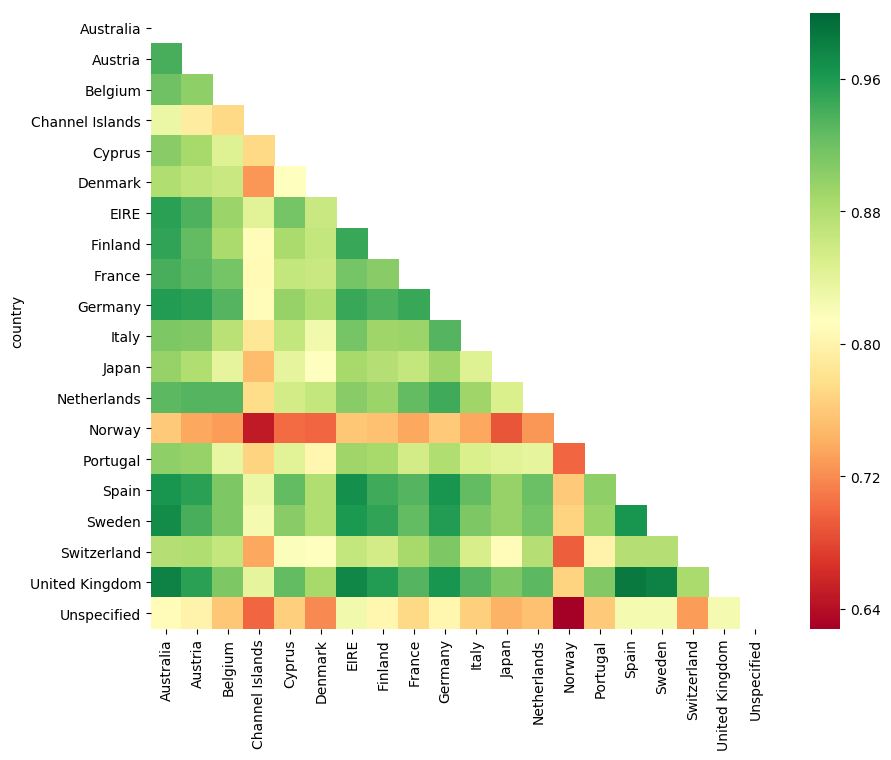

In [232]:
plt.style.use('fast')

fig = plt.figure(figsize=(10,8))
matrix = np.triu(jacc_df.corr())
sns.heatmap(jacc_df, mask=matrix, cmap='RdYlGn')

<Figure size 800x800 with 0 Axes>

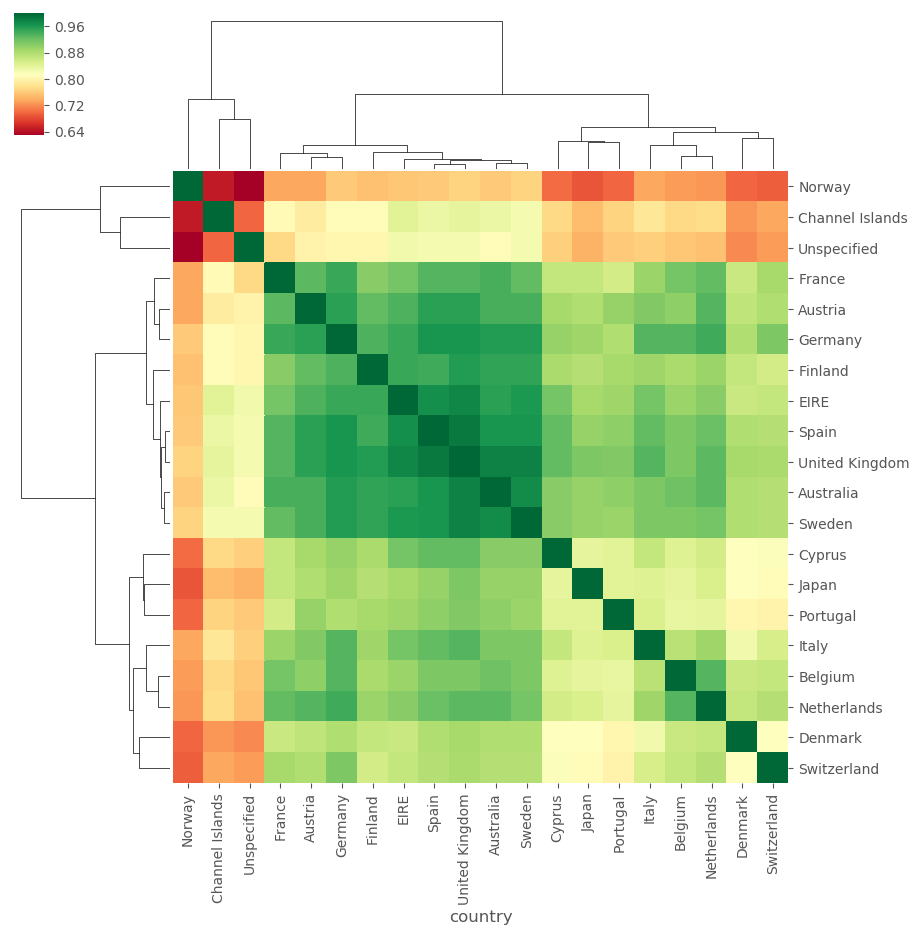

In [236]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(8,8))
sns.clustermap(jacc_df.T, cmap='RdYlGn', method='ward')#, mask=mask)

In [198]:
mask =  np.tri(jacc_df.shape[0], k=1)

mask

array([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1.

In [28]:
cols = freqItems_Country.itemset.unique()

encode_dict = {}
for country in freqItems_Country.country.unique():
    print country
    is_present = []
    tmp = freqItems_Country[freqItems_Country.country == country]
    for i in cols:
        if i in tmp.itemset.values:
            is_present.append(1)
        else: is_present.append(0)
    encode_dict[country] = is_present
    
freq_df = pd.DataFrame.from_dict(encode_dict, orient='index')
freq_df.columns = cols

freq_df

Italy
USA
Unspecified
France
Norway
Australia
Channel Islands
Germany
Belgium
Spain
EIRE
Netherlands
Denmark
Finland
Sweden
Switzerland
Portugal
United Kingdom
Austria
Japan
Cyprus


,['BREAD BIN DINER STYLE IVORY'],['CHILDRENS APRON APPLES DESIGN'],['DOORMAT WELCOME TO OUR HOME'],['FELTCRAFT DOLL MOLLY'],['FELTCRAFT DOLL ROSIE'],['JAM MAKING SET WITH JARS'],['MINT KITCHEN SCALES'],['PLASTERS IN TIN CIRCUS PARADE'],['PLASTERS IN TIN SKULLS'],['PLASTERS IN TIN WOODLAND ANIMALS'],...,['WOODEN PICTURE FRAME WHITE FINISH'],"['AGED GLASS SILVER T-LIGHT HOLDER', 'WHITE HANGING HEART T-LIGHT HOLDER']","['ASSORTED COLOUR BIRD ORNAMENT', 'WHITE HANGING HEART T-LIGHT HOLDER']","['GREEN REGENCY TEACUP AND SAUCER', 'PINK REGENCY TEACUP AND SAUCER']","['GREEN REGENCY TEACUP AND SAUCER', 'ROSES REGENCY TEACUP AND SAUCER']","['PINK REGENCY TEACUP AND SAUCER', 'ROSES REGENCY TEACUP AND SAUCER']","['RED HANGING HEART T-LIGHT HOLDER', 'WHITE HANGING HEART T-LIGHT HOLDER']","['REGENCY CAKESTAND 3 TIER', 'ROSES REGENCY TEACUP AND SAUCER']","['REGENCY CAKESTAND 3 TIER', 'WOOD BLACK BOARD ANT WHITE FINISH']","['GREEN REGENCY TEACUP AND SAUCER', 'PINK REGENCY TEACUP AND SAUCER', 'ROSES REGENCY TEACUP AND SAUCER']"
EIRE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Australia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Italy,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Portugal,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
USA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Denmark,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Finland,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Channel Islands,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Austria,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Unspecified,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


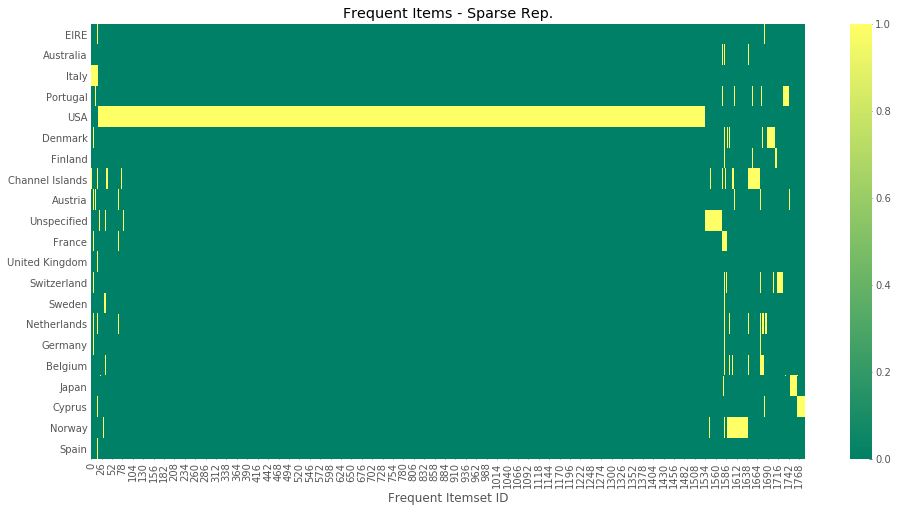

In [29]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
sns.heatmap(freq_df.T.reset_index(drop=1).T, cmap='summer')#, linewidth=.01, linecolor='black')
ax.set_xlabel('Frequent Itemset ID')
ax.set_title('Frequent Items - Sparse Rep.')
plt.xticks(rotation='90');

RuntimeError: maximum recursion depth exceeded while getting the str of an object

<Figure size 1152x576 with 0 Axes>

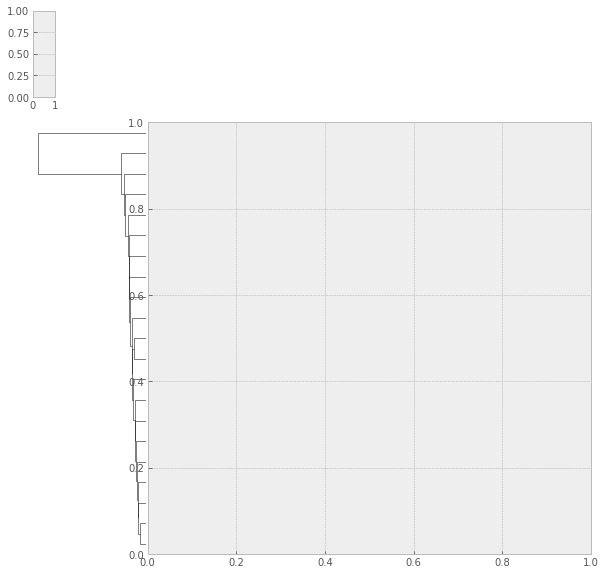

In [30]:
fig = plt.figure(figsize=(16,8))
sns.clustermap(freq_df.T.reset_index(drop=1).T, cmap='summer')#, linewidth=.01, linecolor='black');
plt.title=('Test')

### Drop Poland to improve vis for report

In [ ]:
cols = freqItems_Country.set_index('country').drop('Poland').itemset.unique()

encode_dict = {}
for country in freqItems_Country.country.unique():
    if country not in ['Poland']:
        print country
        is_present = []
        tmp = freqItems_Country[freqItems_Country.country == country]
        for i in cols:
            if i in tmp.itemset.values:
                is_present.append(1)
            else: is_present.append(0)
        encode_dict[country] = is_present
    
freq_df = pd.DataFrame.from_dict(encode_dict, orient='index')
freq_df.columns = cols

#freq_df.to_csv('/Users/areichel/Documents/Personals/DS5230/DS5500_ChangeMining/data/frqItemset_Country_20200330.csv')

In [ ]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
sns.heatmap(freq_df.T.reset_index(drop=1).T, cmap='summer')#, linewidth=.01, linecolor='black')
ax.set_xlabel('Frequent Itemset ID')
ax.set_title('Frequent Items - Sparse Rep.')
plt.xticks(rotation='90');

In [ ]:
fig = plt.figure(figsize=(16,8))
sns.clustermap(freq_df.T.reset_index(drop=1).T, cmap='summer',figsize=(16,12),linewidth=.005, linecolor='dimgrey');
plt.title=('Test')